In [7]:
import pickle 
import numpy as np 
import pandas as pd 
import pingouin as pg 
from scipy.special import softmax 

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'
from scipy.ndimage import gaussian_filter1d


import matplotlib.pyplot as plt 
import seaborn as sns 

import os
import sys
sys.path.append('..')
from utils.fit import fit_bms
from utils.viz import viz 
from utils.analyze import *
from utils.model import *
viz.get_style()
pth = os.path.abspath(os.getcwd())+'/..'

## MOS6 parameter analysis

In [24]:
def show_param(ax, data_set, model, tar, x_var, x0, x1, aux=None):
    titles = {'l1': r'$\lambda_{EU}$', 
                'l2': r'$\lambda_{MO}$', 
                'l3': r'$\lambda_{HA}$',
                'log_alpha': r'log(α)'}
    # preprocess data 
    fname = f'{pth}/simulations/{data_set}/{model}/sim-map.csv'
    valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
    sim_data = pd.read_csv(fname).query(f'sub_id in {valid_sub_lst}')
    sim_data['group'] = sim_data['group'].map(
    {'HC': 'HC', 'MDD': 'PAT', 'GAD': 'PAT'}
    )
    sel_data = sim_data.groupby(by=['sub_id', x_var])[['alpha', 'l1', 'l2', 'l3', 'w1', 'w2', 'w3']].mean().reset_index()
    sel_data['log_alpha'] = sel_data['alpha'].apply(lambda x: np.log(1/(1+np.exp(-x))))       

    # visualize
    viz.violin(ax, data=sel_data, orient='v',
               x=x_var, y=tar, order=[x0, x1], 
               palette=viz.PurplePairs, 
               errorbar='sd', scatter_alpha=.8,
               scatter_size=6.5, mean_marker_size=8,
               errorcolor=[.2]*3)
    ax.set_box_aspect(1.5)
    ax.set_xlabel(titles[tar])
    ax.spines['left'].set_position(('axes',-0.1))
    x_data = sel_data.query(f'{x_var}=="{x0}"')[tar]
    y_data = sel_data.query(f'{x_var}=="{x1}"')[tar]
    t_test(x_data, y_data)
    print(f'\t HC: M={np.mean(x_data.values):.3f}, SD={np.std(x_data.values):.3f}  ')
    print(f'\tPAT: M={np.mean(y_data.values):.3f}, SD={np.std(y_data.values):.3f}  ')
    if aux is not None:
        w1 = sel_data.query(f'{x_var}=="{x0}"')[aux]
        w2 = sel_data.query(f'{x_var}=="{x1}"')[aux]
        print(f'\t HC-{aux}: M={np.mean(w1.values):.3f}, SD={np.std(w1.values):.3f}  ')
        print(f'\tPAT-{aux}: M={np.mean(w2.values):.3f}, SD={np.std(w2.values):.3f}  ')

For λ1...
 	t(54.948)=2.162, p=0.035, cohen-d=0.509
	 HC: M=0.991, SD=1.416  
	PAT: M=0.196, SD=1.736  
	 HC-w1: M=0.500, SD=0.259  
	PAT-w1: M=0.372, SD=0.296  
For λ2...
 	t(60.762)=-3.510, p=0.001, cohen-d=0.801
	 HC: M=-1.647, SD=1.930  
	PAT: M=-0.034, SD=2.091  
	 HC-w2: M=0.141, SD=0.210  
	PAT-w2: M=0.361, SD=0.345  
For λ3...
 	t(56.311)=2.455, p=0.017, cohen-d=0.574
	 HC: M=0.657, SD=1.313  
	PAT: M=-0.162, SD=1.561  
	 HC-w3: M=0.359, SD=0.234  
	PAT-w3: M=0.267, SD=0.245  


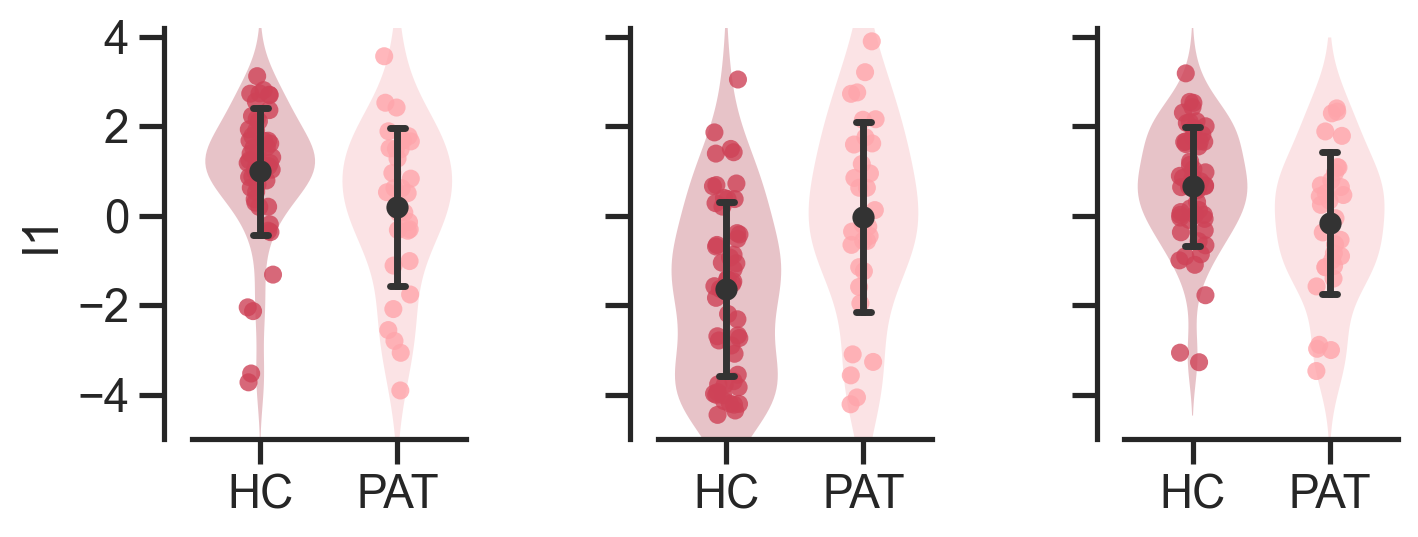

In [25]:
x_var = ['group', 'HC', 'PAT']
model = 'MOS6'
exp = 'exp1data'
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey='row')
for i in range(3):
    print(f'For λ{i+1}...')
    ax = axs[i]
    x_lst = x_var + [f'w{i+1}']
    show_param(ax, exp, model, f'l{i+1}', *x_lst)
    #if i>0: ax.set_yticklabels(['', '']) 
    ax.set_xlabel('')
    ax.set_yticks([-4, -2, 0, 2, 4])
    ax.set_ylim([-5, 4.2])
fig.tight_layout()
plt.savefig(f'../figures/Fig4A_mos6_weight.pdf', dpi=300)

For log α...
 	t(68.692)=0.690, p=0.493, cohen-d=0.151
	 HC: M=-0.492, SD=0.084  
	PAT: M=-0.504, SD=0.079  


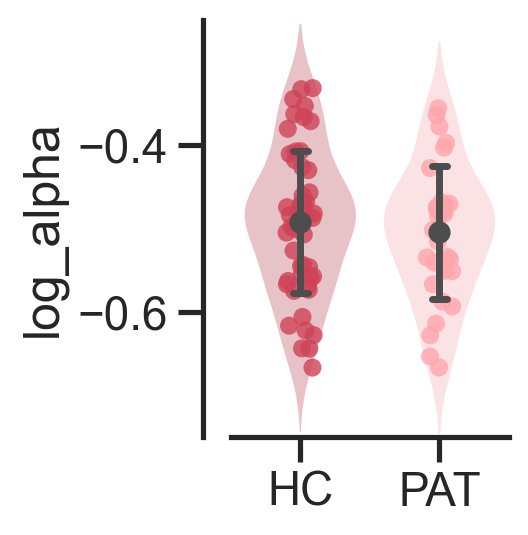

In [23]:
x_var = ['group', 'HC', 'PAT']
model = 'MOS6'
exp = 'exp1data'
fig, axs = plt.subplots(1, 1, figsize=(3.5, 3), sharey='row')
print(f'For log α...')
ax = axs
show_param(ax, exp, model, f'log_alpha', *x_var)
ax.set_xlabel('')
ax.set_ylim([-.75, -.25])
fig.tight_layout()
plt.savefig(f'../figures/Fig4A_logalpha.pdf', dpi=300)

## MOS22 parameter analysis

We used the mixed ANOVA to analyze the parameters of the MOS22 model. This can not be done in PYTHON. We used JASP. 

The following PYTHON code is used to generate data for JASP

In [30]:
model = 'MOS22'
fname = f'{pth}/simulations/exp1data/{model}/sim-map.csv'
valid_sub_lst = pd.read_csv('../data/bifactor.csv').iloc[:, 0].tolist()
sim_data = pd.read_csv(fname).query(f'sub_id in {valid_sub_lst}')
sim_data['group'] = sim_data['group'].map(
{'HC': 'HC', 'MDD': 'PAT', 'GAD': 'PAT'}
)

In [31]:
# get decision preference parameter 
voi = ['l1', 'l2', 'l3']
sel_data = sim_data.groupby(['sub_id', 'group', 'trial_type', 'feedback_type'])[voi].mean().reset_index()
for tar in voi:
    i = 0 
    for t_type in ['sta', 'vol']:
        for f_type in ['gain', 'loss']:
            col = f'{t_type}-{f_type}'
            q = f'trial_type=="{t_type}"&feedback_type=="{f_type}"' 
            sub_data = sel_data.query(q)
            sub_data = sub_data.loc[:, ['sub_id', 'group', tar]].rename(columns={tar: col})
            if i==0: 
                comb_data = sub_data 
            else:
                comb_data = comb_data.merge(sub_data, on=['sub_id', 'group'], how='left')
            i += 1
    comb_data.to_csv(f'{tar}.csv')

In [32]:
# get learning rate parameter 
tar = 'log_alpha'
sel_data = sim_data.groupby(['sub_id', 'group', 'trial_type', 
                    'feedback_type', 'valence_type'])['alpha'].mean().reset_index()
sel_data['log_alpha'] = np.log(sel_data['alpha'])
i = 0 
for t_type in ['sta', 'vol']:
    for f_type in ['gain', 'loss']:
        for o_type in ['bad outcome', 'good outcome']:
            col = f'{t_type}-{f_type}-{o_type}'
            q = f'trial_type=="{t_type}"&feedback_type=="{f_type}"&valence_type=="{o_type}"' 
            sub_data = sel_data.query(q)
            sub_data = sub_data.loc[:, ['sub_id', 'group', tar]].rename(columns={tar: col})
            if i==0: 
                comb_data = sub_data 
            else:
                comb_data = comb_data.merge(sub_data, on=['sub_id', 'group'], how='left')
            i += 1
comb_data.to_csv(f'{tar}.csv')

## Simulate to understand the three strategies

In [3]:
fname = '../simulations/sim/MOS6/sim-map.csv'
data = pd.read_csv(fname, index_col=0)
data['EU'] = data['l1_effect']
data['MO'] = data['l2_effect']
data['HA'] = data['l3_effect']
data['cor_a'] = data.apply(
        lambda x: x['state'] if x['feedback_type']=='gain' else int(1-x['state']) 
    , axis=1)
data['EU_hit'] = data.apply(
    lambda x: x['EU'] if x['cor_a'] else 1-x['EU']
, axis=1)
data['MO_hit'] = data.apply(
    lambda x: x['MO'] if x['cor_a'] else 1-x['MO']
, axis=1)
data['HA_hit'] = data.apply(
    lambda x: x['HA'] if x['cor_a'] else 1-x['HA']
, axis=1)
# remap the vol+sta trial
def get_trial(x):
    if x['block_type']=='vol_sta':
        if x['trial']>89:
            y = x['trial']-90
        else:
            y = x['trial']+90
    else:
        y = x['trial']
    return y 
data['trial'] = data.apply(get_trial, axis=1)
data['a1'] = data['a']

In [4]:
viz_data = {}
# get adaptation
tmp = data.groupby(by=['sub_id', 'trial_type'])[
    ['EU_hit', f'MO_hit', f'HA_hit']
    ].mean().reset_index()
comb_data = [] 
for s in ['EU', 'MO', 'HA']:
    p_table = tmp.pivot_table(
        index='sub_id',
        columns='trial_type',
        values=f'{s}_hit',
        aggfunc='mean'
    ).reset_index()
    p_table['adaptation'] = p_table['vol'] - p_table['sta']
    p_table['strategy'] = s
    comb_data.append(p_table)
comb_data = pd.concat(comb_data, axis=0)

In [5]:
for s in ['EU', 'MO', 'HA']:
    x = comb_data.query(f'strategy=="{s}"')['adaptation']
    m = np.mean(x)
    sd = np.std(x)
    t_test(x, 0, title=f'{s}: {m:.3f}+-{sd:.3f}')
viz_data['adaptation'] = comb_data 

EU: 0.028+-0.043 	t(199.000)=9.016, p=0.000, cohen-d=0.638
MO: 0.002+-0.035 	t(199.000)=0.631, p=0.529, cohen-d=0.045
HA: -0.030+-0.039 	t(199.000)=-10.855, p=0.000, cohen-d=0.768


In [6]:
# hit rate
pool = ['EU', 'MO', 'HA']
sel_data = [] 
for s in pool:
    tmp = data[['sub_id', 'trial', 'group', f'{s}_hit', s]].copy() 
    tmp.rename(columns={f'{s}_hit': 'hit', s: 'a1'}, inplace=True)
    tmp['strategy'] = s
    sel_data.append(tmp)
reshape_data = pd.concat(sel_data, axis=0)
hit_rate_data = reshape_data.groupby(by=['sub_id', 'strategy'])['hit'].mean().reset_index()
viz_data['hit rate'] = hit_rate_data
for s in pool:
    m = hit_rate_data.query(f'strategy=="{s}"')['hit'].mean()
    sd = hit_rate_data.query(f'strategy=="{s}"')['hit'].std()
    print(f'{s}: {m:.3f}+-{sd:.3f}')

EU: 0.643+-0.022
MO: 0.502+-0.017
HA: 0.583+-0.022


In [8]:
# learning curve
tmp = reshape_data.groupby(by=['trial', 'strategy'])['a1'].mean().reset_index()
learn_curve_data = {'trial': [], 'strategy': [], 'a1': []}
for s in pool:
    a1_smooth = gaussian_filter1d(tmp.query(
                f'strategy=="{s}"')['a1'], sigma=2)
    learn_curve_data['trial'] += list(range(a1_smooth.shape[0]))
    learn_curve_data['strategy'] += [s]*a1_smooth.shape[0]
    learn_curve_data['a1'] += a1_smooth.tolist()
learn_curve_data = pd.DataFrame.from_dict(learn_curve_data)
viz_data['learn curve'] = learn_curve_data

In [9]:
# HC vs. PAT learning curve 
tmp = data.groupby(by=['trial', 'group'])['a1'].mean().reset_index()
learn_curve_data = {'trial': [], 'group': [], 'a1': []}
for g in ['HC', 'PAT']:
    a1_smooth = gaussian_filter1d(tmp.query(
                f'group=="{g}"')['a1'], sigma=2)
    learn_curve_data['trial'] += list(range(a1_smooth.shape[0]))
    learn_curve_data['group'] += [g]*a1_smooth.shape[0]
    learn_curve_data['a1'] += a1_smooth.tolist()
learn_curve_data = pd.DataFrame.from_dict(learn_curve_data)
viz_data['HC PAT curve'] = learn_curve_data

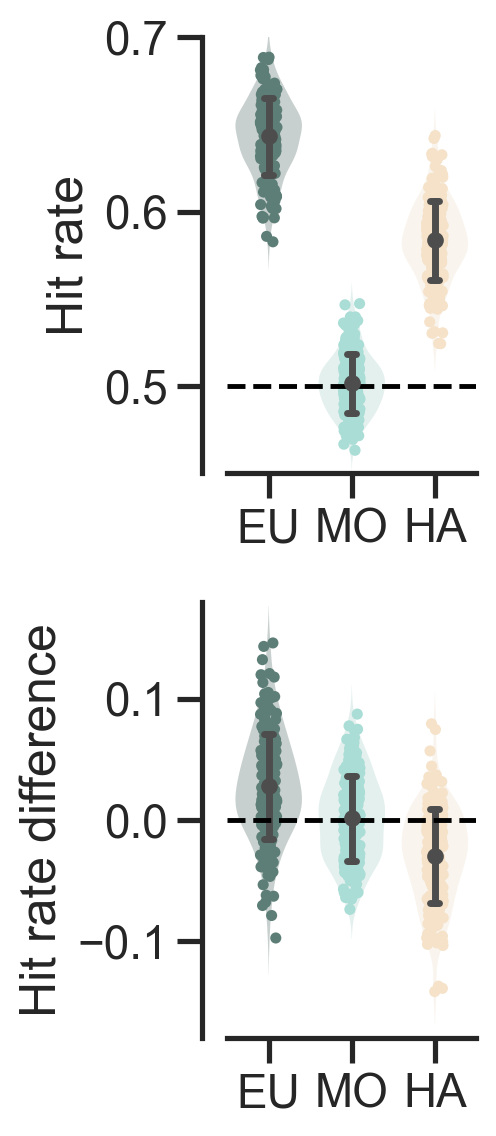

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(3, 6))
ax = axs[0]
viz.violin(ax, data=viz_data['hit rate'], y='hit', 
           x='strategy', order=pool,
           scatter_size=4, errorbar='sd',
           palette=[viz.Pal2_1, viz.Pal2_2, viz.Pal2_3])
ax.axhline(y=.5, xmin=0, xmax=1, ls='--', color='k', lw=1.75)
ax.spines['left'].set_position(('axes',-0.1))
ax.set_box_aspect(1.75)
ax.set_ylim([.45, .7])
ax.set_yticks([.5, .6, .7])
ax.set_ylabel('Hit rate')
ax.set_xlabel('')
ax = axs[1]
viz.violin(ax, data=viz_data['adaptation'], y='adaptation', 
           x='strategy', order=pool,
           scatter_size=4, errorbar='sd',
           palette=[viz.Pal2_1, viz.Pal2_2, viz.Pal2_3])
ax.axhline(y=0, xmin=0, xmax=1, ls='--', color='k', lw=1.75)
ax.spines['left'].set_position(('axes',-0.1))
ax.set_box_aspect(1.75)
ax.set_ylim([-.18, .18])
ax.set_ylabel('Hit rate difference')
ax.set_xlabel('')
fig.tight_layout()
plt.savefig('../figures/Fig4BD_hit_difference.pdf', dpi=300)

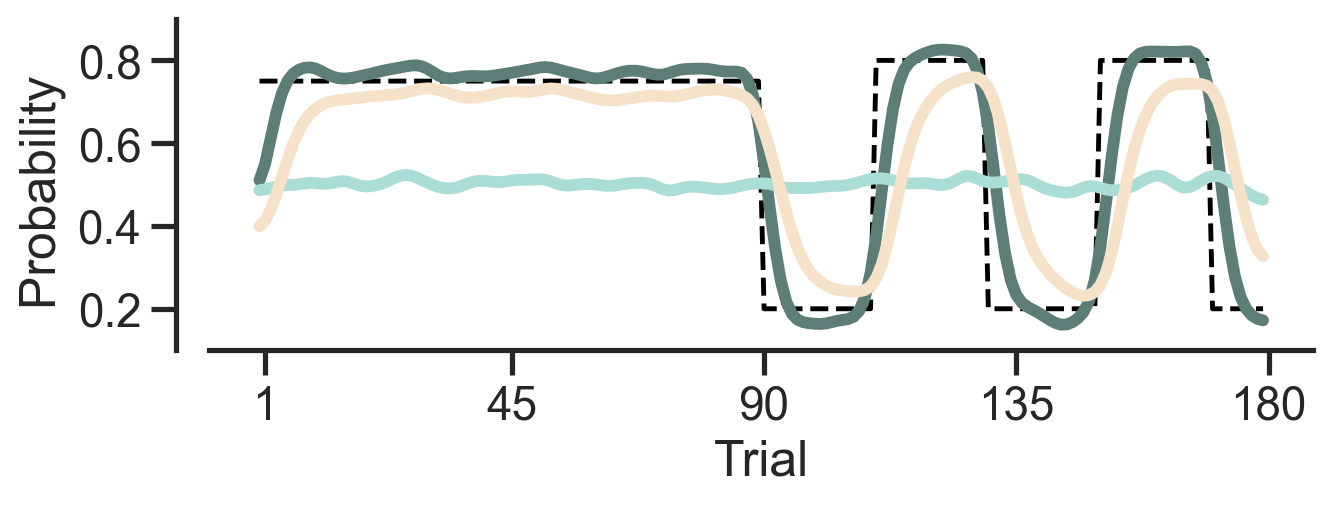

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
psi  = np.zeros([180])
psi[:90]     = .75
psi[90:110]  = .2
psi[110:130] = .8
psi[130:150] = .2
psi[150:170] = .8
psi[170:180] = .2
sns.lineplot(x='trial', y='a1', 
            data=viz_data['learn curve'],
            hue='strategy', hue_order=['EU', 'MO', 'HA'],
            lw=4.25, legend=False,
            palette=[viz.Pal2_1, viz.Pal2_2, viz.Pal2_3])
sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--', lw=1.75, ax=ax, zorder=-10)
ax.set_box_aspect(.3)
ax.spines['left'].set_position(('axes',-0.03))
ax.set_ylim([.1, .9])
ax.set_yticks([.2, .4, .6, .8])
ax.set_xticks([1, 45, 90, 135, 180])
ax.set_ylabel('Probability ')
ax.set_xlabel('Trial')
fig.tight_layout()
plt.savefig('../figures/Fig4C_strategy_curves.pdf', dpi=300)

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
psi  = np.zeros([180])
psi[:90]     = .75
psi[90:110]  = .2
psi[110:130] = .8
psi[130:150] = .2
psi[150:170] = .8
psi[170:180] = .2
sns.lineplot(x='trial', y='a1', data=viz_data['HC PAT curve'],
            hue='group', hue_order=['HC', 'PAT'],
            lw=4.25, legend=False,
            palette=viz.PurplePairs)
sns.lineplot(x=np.arange(180), y=psi, color='k', ls='--', lw=1.75, ax=ax, zorder=-10)
ax.set_box_aspect(.3)
ax.spines['left'].set_position(('axes',-0.03))
ax.set_ylim([.1, .9])
ax.set_yticks([.2, .4, .6, .8])
ax.set_xticks([1, 45, 90, 135, 180])
ax.set_ylabel('Probability ')
ax.set_xlabel('Trial')
fig.tight_layout()
plt.savefig('../figures/Fig4E_HC_PAT_curves.pdf', dpi=300)